In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import os
import xrmreader
import dxchange
from cil.io import ZEISSDataReader
from cil.processors import Binner, TransmissionAbsorptionConverter
from cil.recon import FDK
from cil.framework import AcquisitionGeometry, ImageData, AcquisitionData
import dask

C:\Users\Simon\anaconda3\envs\ndtomo_cil\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
astropy module not found


### Utilities and Change of Class functions

- Need to change the `read` method of `ZEISSDataReader`
- See discussion in [PR 1605](https://github.com/TomographicImaging/CIL/issues/1605) in CIL.

In [2]:
def mask_3D_array(array_3D, mask):
    k = array_3D.shape[0]
    masked_slices = []
    for i in range(k):
        masked_slices.append(mask*array_3D[i])
    return masked_slices


def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask



def revert_shifts(projections, x_shifts, y_shifts):
    '''

    :param projections: projection data
    :param x_shifts: x shift parameter per projection
    :param y_shifts: y shift parameter per projection
    :return: shift corrected porjections
    '''
    num_projections, img_size_x, img_size_y = projections.shape
    shifts = np.zeros((num_projections, 2))
    shifts[:, 0] = x_shifts
    shifts[:, 1] = y_shifts

    # shift each projection
    for i in range(num_projections):
        # input is extended by repeating its last value to avoid zeros after cropping
        projections[i, :, :] = shift(projections[i, :, :], (shifts[i, 1], shifts[i, 0]), order=1, mode='nearest')

    return projections



def new_read(self):
        
    '''
    Reads projections and return Acquisition (TXRM) or Image (TXM) Data container
    '''
    # Load projections or slices from file
    slice_range = None
    if self._roi:
        slice_range = tuple(self._roi)
    data, _ = dxchange.read_txrm(self.file_name,slice_range)

    if isinstance(self._geometry,AcquisitionGeometry):
        # Normalise data by flatfield
        data = data / self._metadata['reference']        
        data = revert_shifts(data, self._metadata["x-shifts"], self._metadata["y-shifts"])
        data = revert_shifts(data, metadata["AMC-x-shifts"], metadata["AMC-y-shifts"])
        data = revert_shifts(data, metadata["temperature-x-shifts"], metadata["temperature-y-shifts"])
        data = revert_shifts(data, metadata["source-x-shifts"], metadata["source-y-shifts"])        
        acq_data = AcquisitionData(array=data, deep_copy=False, geometry=self._geometry.copy(),suppress_warning=True)
        return acq_data
    else:
        ig_data = ImageData(array=data, deep_copy=False, geometry=self._geometry.copy())
        return ig_data
    
ZEISSDataReader.read = new_read


def apply_mask_and_rescale(array, mask):
    masked = dask.delayed(mask_3D_array)(array, mask)
    masked_np = masked.compute()
    rescaled = (masked_np - np.min(masked_np)) / (np.max(masked_np) - np.min(masked_np))
    masked_rescaled = dask.delayed(mask_3D_array)(rescaled, mask)
    return masked_rescaled.compute()

### Path to Datasets

In [3]:
path = r"Z:\Users\Antony\RSIF\microct\raw\20231012_VERSA_3666_AV\20231012_VERSA_3666_AV_2023-10-13_103437\battery_ROI_40s_3201"
filename_sinogram = os.path.join(path, r"20231012_VERSA_3666_AV_battery_ROI_40s_3201.txrm")
filename_recon = os.path.join(path, "20231012_VERSA_3666_AV_battery_ROI_40s_3201_recon.txm")

### Read and show Metadata keys

In [4]:
metadata = xrmreader.read_metadata(filename_sinogram)

for key in metadata.keys():    
    if isinstance(metadata[key], np.ndarray):
        print(key + " = ", metadata[key][0:10])
    else:
        print(key + " = ", metadata[key])

facility =  None
image_width =  990
image_height =  990
data_type =  5
number_of_images =  3201
pixel_size =  0.6653668284416199
reference_exposure_time =  40.0
reference_current =  62.736900329589844
reference_voltage =  159.65757751464844
reference_data_type =  10
image_data_type =  5
thetas =  [-3.14150557 -3.13971379 -3.13758726 -3.13579682 -3.13382475 -3.1318588
 -3.12987048 -3.12791759 -3.12594632 -3.12397931]
x-shifts =  [ 7.03986692 -1.16452694 10.99690437 15.26921082 11.64981365  8.63045502
 13.87889385  6.80217457  4.98658895 16.92324448]
y-shifts =  [ -2.64132261  -5.34183216   6.38877583   0.38299191 -10.88270283
  -0.80797267  -7.86425781  -8.23374367   6.27346754  -5.36798763]
AMC-x-shifts =  [6.94856548 6.92816639 6.90776825 6.88736916 6.86697006 6.84657192
 6.82617283 6.80577374 6.7853756  6.7649765 ]
AMC-y-shifts =  [-0.3459239  -0.34339511 -0.34086633 -0.33833754 -0.33580875 -0.33327997
 -0.33075118 -0.32822239 -0.32569361 -0.32316482]
temperature-x-shifts =  [1.26440

### Load Reconstruction from Zeiss

In [5]:
reader = ZEISSDataReader()
reader.set_up(file_name=filename_recon)
recon = reader.read()  

### Load raw data 

In [6]:
reader = ZEISSDataReader()
reader.set_up(file_name=filename_sinogram)
sinogram = reader.read()

### Preprocessing

In [7]:
absorb = TransmissionAbsorptionConverter()
absorb.set_input(sinogram)
data_absorbed = absorb.get_output()
data_absorbed -= np.mean(data_absorbed.array[:, 0:10,0:10])
data_absorbed.reorder('tigre')

### Compute offset 

In [8]:
center_shift = metadata["center_shift"]
print("center shift is {}".format(center_shift))

sdd = np.abs(metadata["source_isocenter_distance"]) + np.abs(metadata["detector_isocenter_distance"])
sod = metadata["source_isocenter_distance"]

### formula center_shift * metadata["pixel_size"]/1000
object_offset = -center_shift * metadata["pixel_size"]/1000

print("object_offset is {}".format(object_offset)) #0.0005087034880992471

center shift is -0.7645465135574341
object_offset is 0.0005087038889218078


### Correct CIL Geometry for offset and Reconstruct

In [9]:

data_absorbed.geometry.config.system.rotation_axis.position = [object_offset, 0, 0]
data_absorbed.geometry.config.system.source.position = [0, sod, 0]
ig = data_absorbed.geometry.get_ImageGeometry()
ig.voxel_num_x = 956 # 40s dataset


In [10]:
fbp_recon = FDK(data_absorbed, ig).run()

FDK recon

Input Data:
	angle: 3201
	vertical: 990
	horizontal: 990

Reconstruction Volume:
	vertical: 990
	horizontal_y: 990
	horizontal_x: 956

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



### Circular mask to match Zeiss reconstruction 

In [13]:
mask = create_circular_mask(ig.shape[1], ig.shape[2], center=None, radius=475)
fbp_recon_final = apply_mask_and_rescale(fbp_recon.array, mask)
num_slice = 300

In [14]:
img = np.flip(np.array(recon.array[num_slice], dtype="float32")/2**16, axis=0)

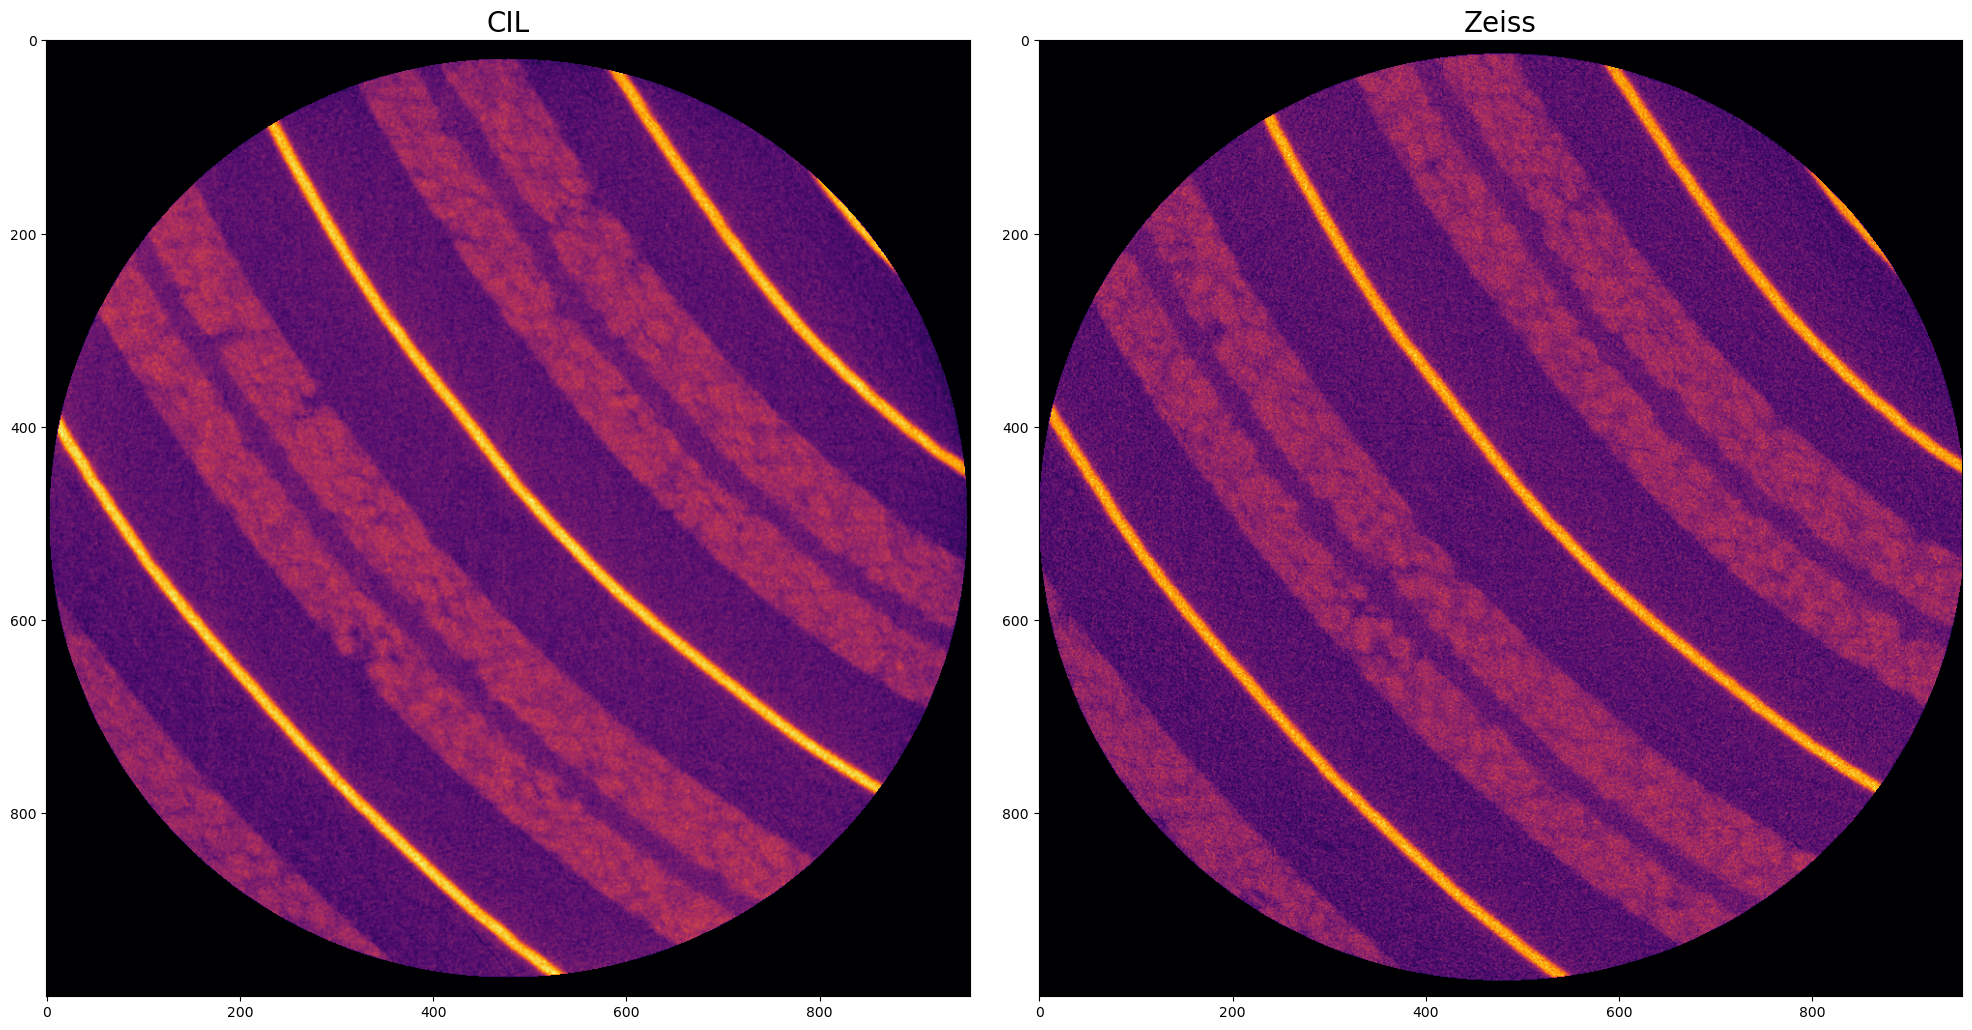

In [16]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fbp_recon_final[num_slice], cmap="inferno")
axs[0].set_title('CIL', fontsize=20)

axs[1].imshow(img, cmap="inferno")
axs[1].set_title('Zeiss', fontsize=20)

plt.tight_layout()
# plt.subplots_adjust(wspace=-0.6, hspace=0.2)

# plt.savefig("cil_vs_zeiss_roi_recon.png")
plt.show()

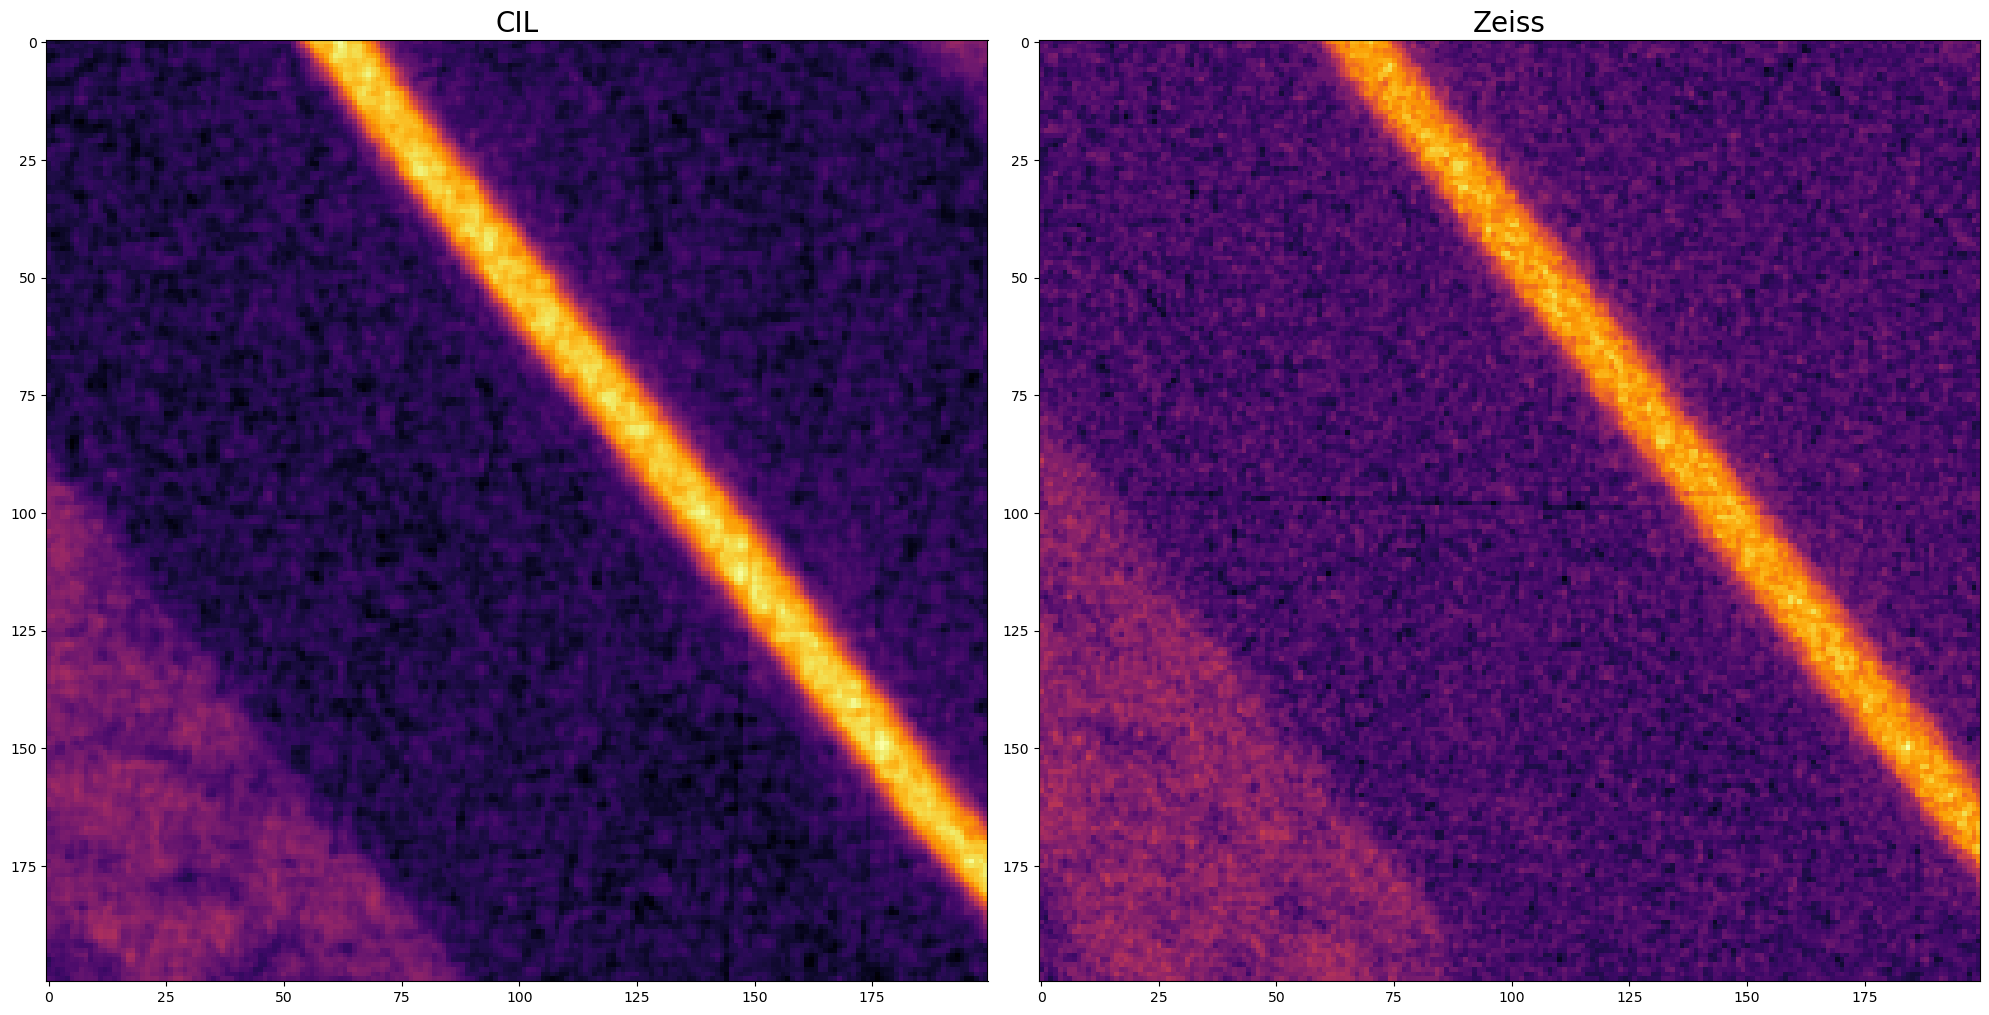

In [21]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fbp_recon_final[num_slice][300:500,300:500], cmap="inferno")
axs[0].set_title('CIL', fontsize=20)

axs[1].imshow(img[300:500,300:500], cmap="inferno")
axs[1].set_title('Zeiss', fontsize=20)

plt.tight_layout()
# plt.subplots_adjust(wspace=-0.6, hspace=0.2)

# plt.savefig("cil_vs_zeiss_roi_recon.png")
plt.show()